Michael Buyer
# Analyzing NBA (National Basketball Association) seasons and team performances since 1949

In [1]:
# cell is for installing packages

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import scipy.stats as stats

The data comes from a wikipedia page of NBA seasons and contains end results of each season. The purpose of this analysis is to primarily look at Top Seeds' performances throughout the years. Thus this will identify how often a top seed becomes a regional champion, and if a particular season's format affected the top seed's record. With the collected data, the only possible factors in teams' performances can be number of teams and games in the season. 

Before looking at season records, there is a summary of how frequently teams become top seed, then there is a summary of statistics of the numerical variables. 

Then a one way F-test is done for two populations of season records depending on if the top seed becomes a regional champion or not. After seeing the T-test's result, the following graphs visualize the data crunched during the one way F-test's computation.

Given more data than what is collected, I would identify more reasons for why the top seed may not become champion.

## Webscraping

In [3]:
page = requests.get("https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_seasons")
soup = BeautifulSoup(page.content, 'html.parser')

#tables = soup.find_all('table')
#for table in tables:
    #print(table.prettify())
    
# the comments above helped find the table of interest, which had the class "wikitable sortable"

resultsTable = soup.find("table", {"class": "wikitable sortable"})
rows = list(resultsTable.find_all("tr")) # tr for table row
rows = rows[4:len(rows)-1] # the first few rows are titles, headers, or are missing data, last row missing data

# Preparing the columns the of the future dataframe
TopSeeds = []; Records = []; Years = []; EastChamps = []; WestChamps = []; Champs = []; NoOfTeams = [];
NoOfGames = []; Notes = [];

# Extracting the data from the table
# A few redundant columns are rejected
for row in rows:
    colData = list(row.find_all("td")) # td for table data (cell)
    # now just appending
    TopSeeds.append(colData[1].get_text())
    Records.append(colData[2].get_text())
    Years.append(colData[3].get_text())
    EastChamps.append(colData[4].get_text())
    WestChamps.append(colData[5].get_text())
    Champs.append(colData[7].get_text())
    NoOfTeams.append(colData[8].get_text())
    NoOfGames.append(colData[9].get_text())
    Notes.append(colData[10].get_text())
    

    
    



## Dataframe Creation

In [4]:

NBA_data = { "Top Seed": TopSeeds, "Season Record": Records, "Year": Years, "Eastern Champion": EastChamps,
           "Western Champion": WestChamps, "Champion": Champs, "Number of Teams": NoOfTeams,
           "Number of Games": NoOfGames, "Notes": Notes}
NBA_data = pd.DataFrame(NBA_data)
print(NBA_data.head()) # can identify what to clean (and there are many things)    
    

               Top Seed    Season Record    Year       Eastern Champion  \
0    Rochester Royals\n   45–15 (.750)\n  1949\n  Washington Capitols\n   
1  Syracuse Nationals\n   51–13 (.797)\n  1950\n   Syracuse Nationals\n   
2  Minneapolis Lakers\n   44–24 (.647)\n  1951\n      New York Knicks\n   
3    Rochester Royals\n   41–25 (.621)\n  1952\n      New York Knicks\n   
4  Minneapolis Lakers\n   48–22 (.686)\n  1953\n      New York Knicks\n   

        Western Champion                 Champion Number of Teams  \
0   Minneapolis Lakers\n     Minneapolis Lakers\n            12\n   
1  Anderson Packers[i]\n  Minneapolis Lakers[j]\n            17\n   
2     Rochester Royals\n       Rochester Royals\n            11\n   
3   Minneapolis Lakers\n     Minneapolis Lakers\n            10\n   
4   Minneapolis Lakers\n     Minneapolis Lakers\n            10\n   

  Number of Games                                              Notes  
0            60\n                               4 NBL teams joi

Cleaning the data was more intensive than expected. When printing the data, first thing to notice is all the '\n' characters. Those are removed immediately. Then sometimes there are brackets as a link to a references in the reference list. Then numeric data is sometimes two numbers with a dash or hyphen in between. The imperfect chosen method was to average the two numbers for number of games. 

As far as the following code, a theme is constantly splitting strings or filtering certain characters.

## Cleaning

In [5]:
NBA_data = NBA_data.replace('\\n',' ', regex=True) # remove all those escape characters

# removing brackets in columns containing team names
# also remove whitespaces in beginning and end
# some data has [i] for example - don't want those
length = len(NBA_data["Top Seed"])
for i in range(0,length):
    words = NBA_data.loc[i,"Top Seed"].split("[") 
    NBA_data.loc[i,"Top Seed"] = words[0].strip()
    words = NBA_data.loc[i,"Eastern Champion"].split("[")
    NBA_data.loc[i,"Eastern Champion"] = words[0].strip()
    words = NBA_data.loc[i,"Western Champion"].split("[")
    NBA_data.loc[i,"Western Champion"] = words[0].strip()
    words = NBA_data.loc[i,"Champion"].split("[")
    NBA_data.loc[i,"Champion"] = words[0].strip()
    
# Number of games is sometimes given as a range, it needs to be just one number
# Also make number of teams a number, not a string
gamesPlayed = []; import re
for i in range(0,length):
    NBA_data.loc[i, "Number of Teams"] = float(NBA_data.loc[i, "Number of Teams"])
    if len(str(NBA_data.loc[i, "Number of Games"])) > 3:
        nums = re.sub("[^0-9]", " ", NBA_data.loc[i,"Number of Games"]) #filtering non-numeric characters
        nums = nums.split()
        gamesPlayed.append(float((int(nums[0]) + int(nums[1]))/2)) # average of two numbers basically rounded down
    else:
        gamesPlayed.append(float(NBA_data.loc[i, "Number of Games"]))
            
NBA_data["Number of Games"] = gamesPlayed



To deal with issues in the season record column, a new Win Proportion column is created, extracting the numbers given in parentheses. Importantly a new column with binary values is created for future analysis.

## Adding/Removing columns

In [6]:
# Make season record into 'win-loss' and another column be win proportion
props = [];
for i in range(0,length):
    seasonRecord = NBA_data.loc[i, "Season Record"]
    records = seasonRecord.split()
    NBA_data.loc[i, "Season Record"] = records[0]; # keeping win-loss
    prop = re.sub("[^0-9]", "", records[1]) # remove parentheses
    prop = int(prop)/10**len(str(prop)) # get number between 0 and 1
    props.append(prop)
NBA_data["Win Proportion"] = props

# naming the index
NBA_data.index.name = "Years after 1949"
# thus I will remove the redundant Year column later

# Finally, I think seeing if a Top Seed became a Champion is useful for future analysis

# Sorry Fort Wayne Pistons but i don't think there should be two "top seeds" (see the wiki table)
NBA_data.loc[6, "Top Seed"] = "Syracuse Nationals"
isChampion = [];
for i in range(0, length):
    seed = NBA_data.loc[i, "Top Seed"];
    if seed in NBA_data.loc[i, "Eastern Champion"] or \
    seed in NBA_data.loc[i, "Western Champion"]:
        isChampion.append(1)
    else:
        isChampion.append(0)
        
NBA_data["Top Seed is a Champion"] = isChampion


## Reordering columns

In [7]:
# also removes a column or two in the process
cols = NBA_data.columns.tolist()
print(cols)
cols.remove("Year")
newCols = cols[0:2]; newCols.append(cols[8]); newCols = newCols + cols[2:5];
newCols.append(cols[9]); newCols = newCols + cols[5:8]
print(newCols)
NBA_data = NBA_data[newCols]


['Top Seed', 'Season Record', 'Year', 'Eastern Champion', 'Western Champion', 'Champion', 'Number of Teams', 'Number of Games', 'Notes', 'Win Proportion', 'Top Seed is a Champion']
['Top Seed', 'Season Record', 'Win Proportion', 'Eastern Champion', 'Western Champion', 'Champion', 'Top Seed is a Champion', 'Number of Teams', 'Number of Games', 'Notes']


In [8]:
print(NBA_data.head())

                            Top Seed Season Record  Win Proportion  \
Years after 1949                                                     
0                   Rochester Royals         45–15           0.750   
1                 Syracuse Nationals         51–13           0.797   
2                 Minneapolis Lakers         44–24           0.647   
3                   Rochester Royals         41–25           0.621   
4                 Minneapolis Lakers         48–22           0.686   

                     Eastern Champion    Western Champion            Champion  \
Years after 1949                                                                
0                 Washington Capitols  Minneapolis Lakers  Minneapolis Lakers   
1                  Syracuse Nationals    Anderson Packers  Minneapolis Lakers   
2                     New York Knicks    Rochester Royals    Rochester Royals   
3                     New York Knicks  Minneapolis Lakers  Minneapolis Lakers   
4                     N

## Summarize what teams were top seed most frequently

{'Minneapolis Lakers': 3, 'Boston Celtics': 18, 'Philadelphia 76ers': 4, 'Milwaukee Bucks': 4, 'Los Angeles Lakers': 6, 'Golden State Warriors': 4, 'Chicago Bulls': 5, 'San Antonio Spurs': 5, 'others': 23}


Text(0.5, 1.0, '8 NBA teams that were top seed most frequently')

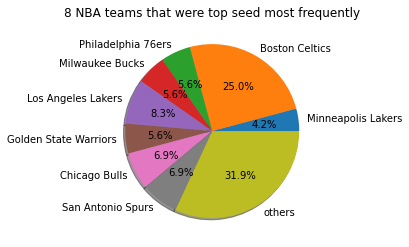

In [9]:
# function counting frequencies (helps for pie, frequency chart)
def CountFrequency(my_list):
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)
    return freq
 
teams = list(NBA_data["Top Seed"])
teamFreq = CountFrequency(teams); others = 0; # put all the teams with < 3 times being top seed into "others"
for key in teamFreq:
    if teamFreq[key] < 3:
        others += teamFreq[key];
        
        
newTeamFreq = {k: v for k, v in teamFreq.items() if v > 2}
newTeamFreq["others"] = others
print(newTeamFreq)
        
# now make the pie chart
plt.pie(newTeamFreq.values(), labels = newTeamFreq.keys(), autopct = '%1.1f%%', shadow = True)
plt.title("8 NBA teams that were top seed most frequently")

## Identifying Outlier Seasons

Logically, one would think that there is a proportional relationship between the number of teams and number of games of played. So that theory is tested with a scatter plot, which will also identify possible outliers.

Text(0.5, 1.0, 'Number of Games Played versus Teams Playing')

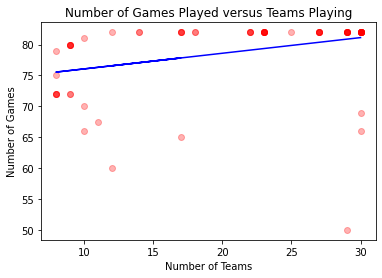

In [10]:

x = NBA_data["Number of Teams"].astype(str).astype(float); 
y = NBA_data["Number of Games"].astype(str).astype(float);
plt.scatter(x, y, alpha = 0.3, color = "red")
m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b, color = "blue")
# note: this regression line is not robust to outliers yet it represents the data well
plt.xlabel("Number of Teams"); plt.ylabel("Number of Games");
plt.title("Number of Games Played versus Teams Playing")

In [11]:
# See the notes of the one season with less than 60 games
print(NBA_data['Notes'][NBA_data['Number of Games'] < 55])
# the season's year = 1949 + 50 = 1999

Years after 1949
50    Season delayed and shortened due to a lockout 
Name: Notes, dtype: object


In [12]:
# Other notes for a season having less than 70 games
print(NBA_data['Notes'][NBA_data['Number of Games'] < 70])
# lockouts, then most recent season(s) suspended due to covid for example

Years after 1949
0                                   4 NBL teams joined 
1     NBL merged with BAA and was renamed NBA;2 team...
2     6 teams folded;1 team folded during the season...
3                                                      
50       Season delayed and shortened due to a lockout 
63       Season delayed and shortened due to a lockout 
71    Season suspended from March 11 to July 29, 202...
Name: Notes, dtype: object


## Descriptive Statistics

In [13]:
NBA_data_numeric = NBA_data[["Win Proportion","Number of Teams","Number of Games","Top Seed is a Champion"]]

# not grouped by if top seed became a champion
NBA_data_numeric.describe()


,Win Proportion,Number of Games,Top Seed is a Champion
count,72.000000,72.000000,72.000000
mean,0.752111,78.895833,0.583333
std,0.060634,6.299417,0.496466
min,0.597000,50.000000,0.000000
25%,0.724250,80.000000,0.000000
50%,0.756000,82.000000,1.000000
75%,0.793000,82.000000,1.000000
max,0.890000,82.000000,1.000000


In [14]:
#grouped
NBA_data_numeric.groupby("Top Seed is a Champion").describe()

Win Proportion                                     \
                                count     mean       std    min      25%   
Top Seed is a Champion                                                     
0                                30.0  0.74220  0.047993  0.621  0.72300   
1                                42.0  0.75919  0.067928  0.597  0.72675   

                                            Number of Games             \
                          50%    75%    max           count       mean   
Top Seed is a Champion                                                   
0                       0.753  0.768  0.829            30.0  79.216667   
1                       0.756  0.805  0.890            42.0  78.666667   

                                                                 
                             std   min    25%   50%   75%   max  
Top Seed is a Champion                                           
0                       6.288582  60.0  82.00  82.0  82.0  82.0  
1                       6.373216  50.0  79.25  82.0  82.0  82.0

Now the win proportion means seem very similar, but the given data is on a small scale between 0 and 1.
A One way F-test can answer if the means for top seed is/ is not a champion are different or not. If means are not significantly different, then win proportions are the same or similar regardless of the top seed becoming a champion (teams might have tied records). If means are significantly different, then the top seed won more often to become champion than otherwise (top seed might have dominated the season)

## One way F-test

In [15]:

stats.f_oneway(NBA_data_numeric['Win Proportion'][NBA_data_numeric['Top Seed is a Champion'] == 1], 
               NBA_data_numeric['Win Proportion'][NBA_data_numeric['Top Seed is a Champion'] == 0])

# statistic = 1.3814729446352012
# p-value = 0.24383279660875418
# no evidence being a champion is significant to the proportion of games won in the season 

F_onewayResult(statistic=1.3814729446352012, pvalue=0.24383279660875418)

If I had access to more data such as how every team did in the season, I would do ANOVA to understand win proportions more such as if they are extreme (last place losing every game, first place winning every game) or more balanced (no team won more than 80% of the time)

Then If I knew the top player and their team's performance, I could see how much of an affect having the top player has on the team's performance, which sounds like one-way ANOVA or T-test.

Now a boxplot to visualize descriptive statistics and the above test

Text(0.5, 1.0, "Distribution of Top Seed's Win Proportion, based on Championship Success or not ")

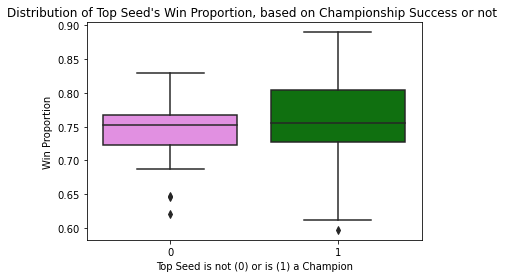

In [16]:

sns.boxplot(x = NBA_data["Top Seed is a Champion"], y = NBA_data["Win Proportion"], palette = ["violet","green"])
plt.xlabel("Top Seed is not (0) or is (1) a Champion")
plt.title("Distribution of Top Seed's Win Proportion, based on Championship Success or not ")

 Means are almost identical visually, but the spread (standard deviation) of the right is larger than the left
 clearly. Based on the quartiles, the Top Seed usually does better than 0.72, regardless of their future status
 as champion. But if the top seed ends up being a champion, they are more likely to have a better record.

Text(0.5, 1.0, 'Density distribution of Top Seed Win Proportions')

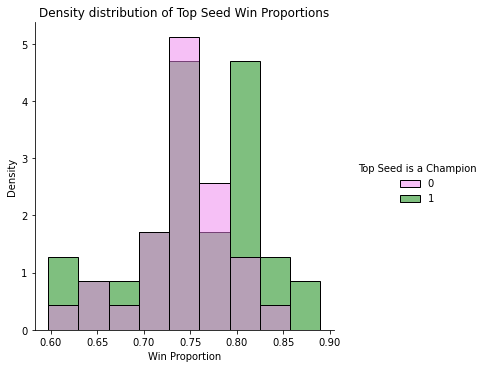

In [17]:

sns.displot(data = NBA_data, x= "Win Proportion", hue="Top Seed is a Champion", palette = ["violet","green"], 
            stat = "density")
plt.title('Density distribution of Top Seed Win Proportions')

The density distribution is chosen to see much the data overlaps and to see where it does not overlap. Interesting how green is seen on both left and right and violett is seen in the center. This reinforces the difference in standard deviations, which was computed a while back. It also explains the T-test's result - the champion can have 0.85 winning proportion but it can also be as low as 0.62.